# Using the ELBO in practice

## Introduction

In the previous post, we derived the ELBO in practice. We saw that by maximising the lower bound, given by;

$$E_{q}[log \ P(X,Z) - log \ q(Z)] = \mathcal{L}$$

we can approximate the posterior $P(Z\mid X)$ with $q(Z)$.

For this post, I will go through how we can use Tensorflow to to learn an approximation to the true posterior.

## Computing the ELBO in practice

What we will concerned with in this post is how to compute the ELBO in practice, without having to resort to special case simplifications. This approach forms part of a set of approaches termed 'Black Box' Variational Inference. 

$$\mathcal{L} = E_{q}[log \ P(X,Z) - log \ q(Z)] $$

The advantage of this formulation is that as we want a tractable approximation it should be simple to sample from $q$. This means we are able to approximate the Expecation as;

$$E_{q}[log \ P(X,Z) - log \ q(Z)] \approx \frac{1}{M}\sum_{i}^{M} [log \ P(X, Z_{i}) - log \ q(Z_{i})]$$

Where $Z_{i}$ is sampled under $q$.

We can split these terms out a little to make things a little easier;

$$ = \frac{1}{M}\sum_{i}^{M} log \ P(X \mid Z_{i}) + \frac{1}{M}\sum_{i}^{M}log \ P(Z_{i}) - \frac{1}{M}\sum_{i}^{M}log \ q(Z_{i})$$

As the likelihood is almost always I.I.D, we can further split up the likelihood term;

$$ = \frac{1}{M}\sum_{i}^{M} \sum_{j}^{N}log \ P(X_{j} \mid Z_{i}) + \frac{1}{M}\sum_{i}^{M}log \ P(Z_{i}) - \frac{1}{M}\sum_{i}^{M}log \ q(Z_{i})$$

Using the above formula we can easily compute a Monte carlo estimate of the ELBO, irrelevant of the form of the joint distribution.

There is one subtly, however, lurking beneath the surface. 

## Using the MC ELBO estimate

The esimate we have derived above is very simple to implement providing we can evaluate the joint distribution and we can sample from $q$.

Our goal is to maximise the ELBO, using the MC approximation. If we wish to use a library like tensorflow, or other library which uses automatic differentiation in order to do gradient based optimization, we have to ensure that all the gradients flow correctly.

In a general sense, sampling is not an operation over which gradients will flow under automatic differentiation. Intuitively, we can see this is the case because sampling is non-deterministic, so the gradients will also be non-deterministic. We will explore this further in a future post.

One way to get around this is to use the so-called [Reparameterization Trick](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/). Within Tensorflow, all variables that implement some method for sampling over which gradients will flow have a FULLY_REPARAMETERIZED flag. You can see this check in the code that follows.

In future posts, we will look into the details of the Reparameterization Trick, as well as ways to deal with distributions where this is not possible.



In [2]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Problem setup

In order to introduce the ELBO, and to be able to examine the results, we will use a conjugate distribution so we can easily derive the analytical solution.

We will use a simple linear regression, treating the weights, $W$ as our latent variable.

$$P(W) = N(W; 0.8, 1.0)$$

$$P(t\mid X, W) = N(t; y, S_{N})$$

where $y = Xw$

Our aim is to compute an approximation to the posterior $P(W| \ t, \ X)$. 

Firstly, we will generate the data we will use.

In [3]:
N = 200

X = np.random.uniform(low=-50, high=50, size=(N, 1))
T = 3.2*X + np.random.normal(size=(N, 1), scale=5.5)

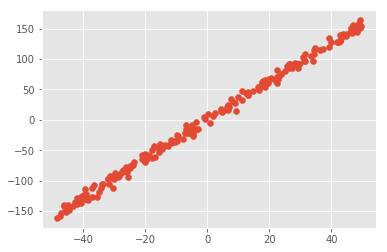

In [4]:
plt.scatter(X,T)

In [5]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [6]:
class MCElbo(torch.nn.Module):
    def __init__(self):
        super(MCElbo, self).__init__()
        self.n_latent = 100 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        
        #The parameters we adjust during training.
        self.qm = torch.nn.Parameter(torch.randn(1,1), requires_grad=True)
        self.qs= torch.nn.Parameter(torch.randn(1,1), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_m = Variable(torch.randn(1,1), requires_grad=False)
        self.prior_s = Variable(torch.randn(1,1), requires_grad=False)
        self.likelihood_s = Variable(torch.FloatTensor((1)), requires_grad=False)
        
        #Set the prior and likelihood moments.
        self.prior_s.data.fill_(1.0)
        self.prior_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)
     
        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,1))
    
    def reparam(self, eps):
        eps = Variable(torch.FloatTensor(eps))
        return  eps.mul(self.softplus(self.qs)).add(self.qm)
    
    def compute_elbo(self, x, t):
        eps = self.generate_rand()
        z = self.reparam(eps)
        q_likelihood = torch.mean(log_norm(z, self.qm, self.softplus(self.qs)))
        prior = torch.mean(log_norm(z, self.prior_m, self.prior_s))
        likelihood = torch.mean(torch.sum(log_norm(t, x*z.transpose(0,1), 
                                                   self.likelihood_s), 0))
        
        kld_mc = q_likelihood - prior
        loss = likelihood - kld_mc
        return loss

In [7]:
c = MCElbo()
optimizer = torch.optim.Adam(c.parameters(),lr=0.2)
x = Variable(torch.Tensor(X), requires_grad=False) 
t = Variable(torch.Tensor(T), requires_grad=False)

for i in range(2001):
    loss = -c.compute_elbo(x, t)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    if i % 250 ==0:
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[0.12696537]] [[0.12256405]]
[[3.1920013]] [[0.00029016]]
[[3.1917012]] [[0.00019842]]
[[3.1924832]] [[0.00017931]]
[[3.1917026]] [[0.00017949]]
[[3.1894362]] [[0.00017801]]
[[3.192994]] [[0.00017509]]
[[3.1909337]] [[0.00017181]]
[[3.1911685]] [[0.00017638]]


In [8]:
analytical_posterior_var = ((1/5.5**2)*X.T@ X +1)**-1
analytical_posterior_var

array([[0.00017682]])

In [9]:
analytical_posterior_mean = analytical_posterior_var*(0.9+((1/5.5**2)*X.T @ T))
analytical_posterior_mean

array([[3.19167208]])

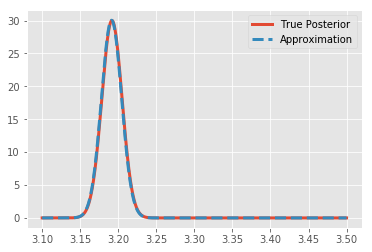

In [10]:
from scipy.stats import norm
xn = np.arange(3.1, 3.5, 0.0001)
true_dist = norm(loc = analytical_posterior_mean, 
                 scale =(analytical_posterior_var)**0.5)
q_dist = norm(loc = c.qm.data.numpy(), scale = c.softplus(c.qs).data.numpy())
yn = true_dist.pdf(xn).ravel()
plt.plot(xn, yn, linewidth=3, label="True Posterior")
plt.plot(xn, q_dist.pdf(xn).ravel(), '--', linewidth=3,
         label="Approximation")
plt.legend()
